## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

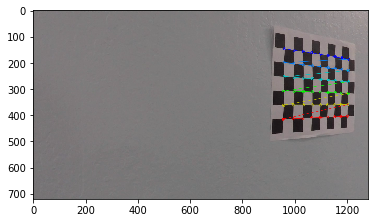

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

# cv2.destroyAllWindows()

In [3]:
img = cv2.imread(images[3])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

True

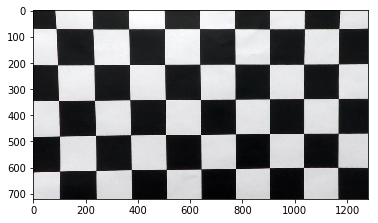

In [4]:
img = cv2.imread('../camera_cal/calibration1.jpg')
undistorted_cali = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undistorted_cali)
cv2.imwrite('../output_images/undistorted_cali.jpg', undistorted_cali)

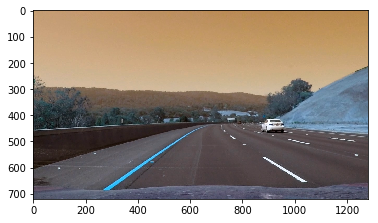

In [5]:
img = cv2.imread('../test_images/test3.jpg')
plt.imshow(img)

True

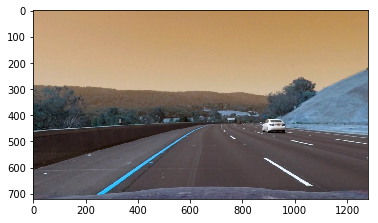

In [6]:
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undistorted_img)
cv2.imwrite('../output_images/undistorted_img.jpg', undistorted_img)

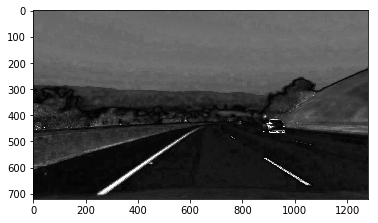

In [7]:
hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
plt.imshow(s_channel, cmap='gray')

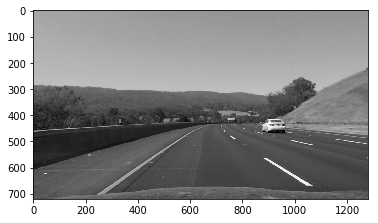

In [8]:
gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

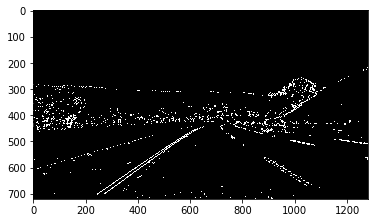

In [9]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

plt.imshow(sxbinary, cmap='gray')

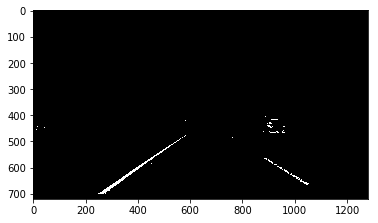

In [10]:
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
plt.imshow(s_binary, cmap='gray')

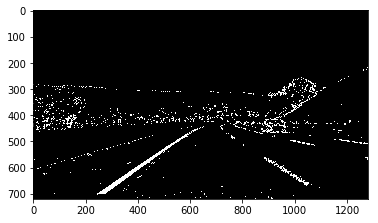

In [11]:
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
plt.imshow(combined_binary, cmap='gray')
plt.savefig('../output_images/binary_combo.jpg')

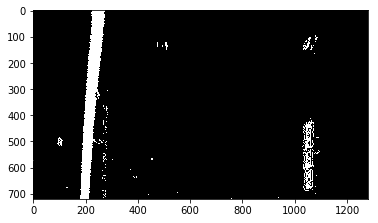

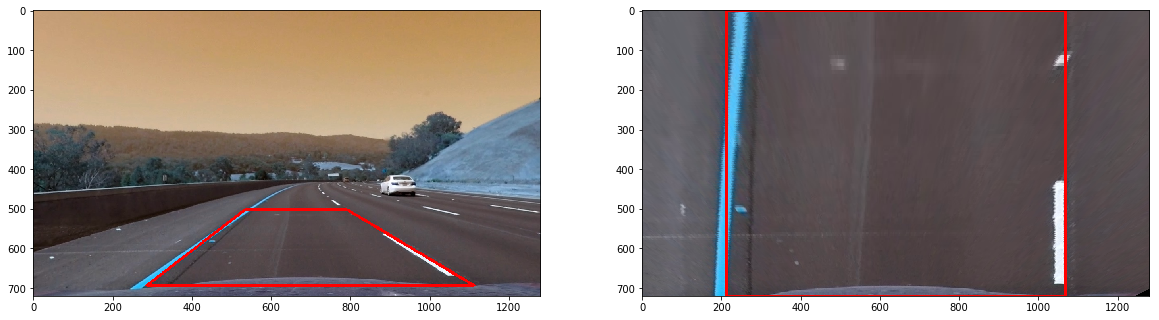

In [12]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

img_size = (img.shape[1], img.shape[0])
src = np.float32(
    [[534, 502],
     [286, 693], 
     [1111, 693],
     [791, 502]])
dst = np.float32(
    [[(img_size[0] / 6), 0],
    [(img_size[0] / 6), img_size[1]],
    [(img_size[0] * 5 / 6), img_size[1]],
    [(img_size[0] * 5 / 6), 0]])

warped = warper(combined_binary, src, dst)
plt.imshow(warped, cmap='gray')

warped_output = warper(undistorted_img, src, dst)
warped_output0 = undistorted_img.copy()
# cv2.line(warped_output, tuple(dst[0]), tuple(dst[1]), (255, 0, 0), 5)
# cv2.line(warped_output, tuple(dst[-2]), tuple(dst[-1]), (0, 0, 255), 5)
cv2.polylines(warped_output, np.int32([dst]), True, (255, 0, 0), 5)
cv2.polylines(warped_output0, np.int32([src]), True, (255, 0, 0), 5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(warped_output0)
ax2.imshow(warped_output)
f.savefig('../output_images/warped_straight_lines.jpg')


In [13]:
dst

array([[  213.33332825,     0.        ],
       [  213.33332825,   720.        ],
       [ 1066.66662598,   720.        ],
       [ 1066.66662598,     0.        ]], dtype=float32)

True

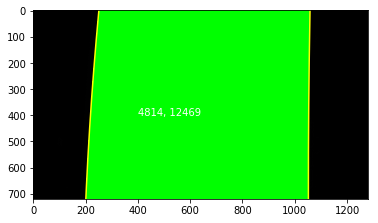

In [14]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        # (win_xleft_high,win_y_high),(0,255,0), 2) 
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),
        # (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, dst):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    ## Visualization ##

    left_pts = np.array([[y, x] for y, x in zip(left_fitx, ploty)])
    right_pts = np.array([[y, x] for y, x in zip(right_fitx, ploty)])

    cv2.fillPoly(out_img, np.int32([np.concatenate([left_pts, np.flip(right_pts, axis=0)])]), (0, 255, 0)) 

    # Colors in the left and right lane regions
    # out_img[lefty, leftx] = [255, 0, 0]
    # out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.text(400, 400, "%d, %d" % (left_curverad, right_curverad), {'color': 'white'})

    return out_img, min(left_curverad, right_curverad), ((right_fitx[-1]+left_fitx[-1])/2 - img_size[0]/2)*xm_per_pix


out_img, curverad, distance = fit_polynomial(warped, dst)

plt.imshow(out_img)
cv2.imwrite('../output_images/color_fit_lines.jpg', out_img)

True

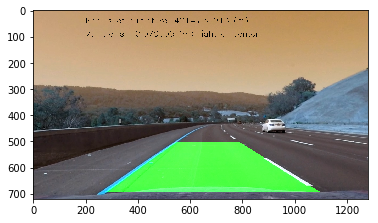

In [15]:
filter = warper(out_img, dst, src)
plt.imshow(filter)
res = cv2.addWeighted(undistorted_img, 1, filter, 0.8, 1)
cv2.putText(res, "Radius of curvature: %1f (m)" % curverad, (200, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0))
cv2.putText(res, "Vehicle is %1f (m) right of center" % distance, (200, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0))
plt.imshow(res)
cv2.imwrite('../output_images/output.jpg', res)

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
class LaneDetectCache():
    def __init__(self):
        self.radius_cache = np.array([2500])
        self.curr_mean = -1
    
    def update_radius(self, new_radius):
        if len(self.radius_cache) < 10:
            self.radius_cache = np.append(self.radius_cache, [new_radius])
            self.curr_mean = np.mean(self.radius_cache)
        elif np.abs(self.curr_mean - new_radius) > 5000:
            pass
        else:
            self.radius_cache = np.append(np.delete(self.radius_cache, 0), [new_radius])
            self.curr_mean = np.mean(self.radius_cache)

        return self.curr_mean

In [18]:
def process_image(img):
    
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[534, 502],
        [286, 693], 
        [1111, 693],
        [791, 502]])
    dst = np.float32(
        [[(img_size[0] / 6), 0],
        [(img_size[0] / 6), img_size[1]],
        [(img_size[0] * 5 / 6), img_size[1]],
        [(img_size[0] * 5 / 6), 0]])

    warped = warper(combined_binary, src, dst)
    
    out_img, curverad, distance = fit_polynomial(warped, dst)
    curverad = cache.update_radius(curverad)
    filter = warper(out_img, dst, src)
    plt.imshow(filter)
    res = cv2.addWeighted(undistorted_img, 1, filter, 0.8, 1)
    cv2.putText(res, "Radius of curvature: %1f (m)" % curverad, (200, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0))
    cv2.putText(res, "Vehicle is %1f (m) right of center" % distance, (200, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0))
    
    return res

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [02:05<00:00,  8.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 5min 5s, sys: 4.31 s, total: 5min 9s
Wall time: 2min 6s


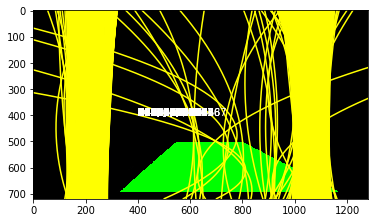

In [19]:
output = '../project_video_output.mp4'

cache = LaneDetectCache()
clip1 = VideoFileClip("../project_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./challenge_video_output.mp4
[MoviePy] Writing video ./challenge_video_output.mp4


100%|██████████| 485/485 [00:39<00:00, 12.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_output.mp4 

CPU times: user 1min 48s, sys: 2.1 s, total: 1min 50s
Wall time: 40.2 s


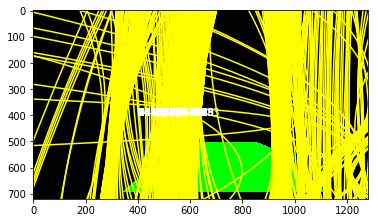

In [20]:
output = '../challenge_video_output.mp4'

clip1 = VideoFileClip("../challenge_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)